### Question 2

library

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from copy import deepcopy
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from kneed import KneeLocator
from wordcloud import WordCloud
import gc

Kmeans implementation

In [10]:
def k_means(data, k, max_it=300):
    
    # define centroids randomly
    idx = np.random.choice(data.shape[0], k)
    centroids = data[idx, :]
    
    it = 0
    loop = True
    while loop and it < max_it:
        
        # assigned cluster's labels
        labels = np.empty(len(data), dtype='p')
        clusters = defaultdict(list)
        for f in range(len(data)):
            d = list()
            for i in range(k):
                d.append(np.sqrt(np.sum((data[f] - centroids[i])**2)))
            idx = d.index(min(d))
            labels[f] = idx
            clusters[idx].append(data[f])

        # calculate new centroids
        old_centroids = deepcopy(centroids)
        for i in range(k):
            centroids[i] = np.average(clusters[i], axis=0)

        # check the convergence
        comparison = old_centroids == centroids
        if comparison.all():
            loop = False
        it += 1
    
    return clusters, labels

Document opening

In [2]:
ds = pd.read_csv('D:/Storage file PC/Documenti/Università/Data Science/Anno 1/Semestre 1/Algorthmic Methods of Data Mining/Homeworks/HW4/Question2/Reviews.csv')

In [17]:
ds.sample(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
484754,484755,B0018R2QMO,AYTWGAPC3ICFH,Candy,0,0,5,1298937600,Greaaaaaaaaaaaaaat,My sister got some of these for me and now I'm...
70554,70555,B000FNB3AI,A1VMHSYTTWSNUA,M. Hamington,0,3,5,1167782400,tasty and good for you,"If you must have a cookie, might as well make ..."
474213,474214,B004DCGBXQ,A26MNXNUVP2LPS,Nick & Erica,0,1,3,1334707200,Childhood memories,These were one of my favorite treats when I wa...
222896,222897,B000UUWECC,A2VO8WD91S0Y3G,"Target is the new nordstrom ""PG""",0,0,1,1337472000,"TERRIBLE TASTE, DO NOT BUY THE 12 Pack",I agree with another reviewer. I have been dri...
392577,392578,B000SANUB8,A22DAD6FX3FAN6,"Marcus Welby ""Marcus""",1,1,4,1298678400,Large leaf but good flavor,"This is very large leaf tea, so you'll need to..."
305921,305922,B008BY7O9W,A3PX9WSJ2WIVJQ,Caitlin M. Milligan,1,1,5,1316476800,great find!,I stumbled upon this product while doing an Am...
37498,37499,B002EY8BAG,A11J5JABO627LW,Kelly C Orzechowski,0,0,4,1336521600,Awesome bar!,"As a vegetarian and a runner, I needed to find..."
72692,72693,B004X3VRLG,AQH1SWR5HA413,"Donnie Darko ""Donnie Darko""",0,0,5,1310601600,Our dogs really liked these healthy treats,"We love our pets and always look for new, heal..."
331483,331484,B000GBH61O,A31ZCAL11QQPI,Dr. C.,1,1,5,1231027200,loved it,"I think this was great. However, being a typi..."
100315,100316,B00954NYVY,A2R8UB60Y7LFYO,shell,1,1,2,1344297600,Delicious but not that strong,I'm on a quest for the boldest k-cup coffee......


In [18]:
ds.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

Clean dataset

In [3]:
ds['ProfileName'].fillna('', inplace=True)
ds['Summary'].fillna('', inplace=True)

In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [4]:
ds.set_index('Id', inplace=True)

In [7]:
ds.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

clean_text = lambda text : [lemmatizer.lemmatize(word.lower()) \
                for word in word_tokenize(text) \
                if word.lower() not in stop_words and word.isalpha()]

In [8]:
clean_text("I'm fallen in love with Data Mining")

['fallen', 'love', 'data', 'mining']

In [9]:
wordlist = ds['Text'].apply(clean_text)

In [12]:
ds['wordlist'] = wordlist

In [13]:
s = pd.Series(flat_list).value_counts()

In [81]:
ds.sample()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,wordlist
Id,,,,,,,,,,
396404,B000YBXKN4,A297MV0W8RSCW1,Christopher Dowell,0,0,5,1245542400,Great drink from Scandinavia!,Only in the Nordic territories!<br /> This dri...,"[nordic, territory, br, drink, great, br, tail..."


In [110]:
top2k_word = []
for word, count in s[:2000].iteritems():
    top5k_word.append(word)

In [17]:
products = list(ds.ProductId.unique())

In [172]:
d = defaultdict(list)

for i in tqdm(ds.index):
    d[ds.ProductId[i]] += ds.wordlist[i]

100%|██████████| 568454/568454 [00:29<00:00, 19223.67it/s]


In [12]:
data = np.zeros((len(products), len(top2k_word)))

In [13]:
for w in tqdm(top2k_word):
    for p in products:
        if w in d[p]:
            data[products.index(p), top2k_word.index(w)] = 1

100%|██████████| 2000/2000 [1:45:18<00:00,  3.16s/it] 


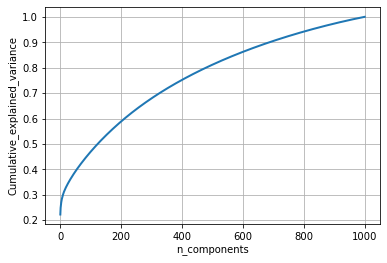

In [16]:
svd = TruncatedSVD(n_components = 1000)
svd_2000 = svd.fit_transform(data)

percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

plt.figure(figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [17]:
svd = TruncatedSVD(n_components = 250)
svd_2000 = svd.fit_transform(data)

In [18]:
elbow = {}
for k in tqdm(range(3, 30)):
    elbow_model = KMeans(n_clusters=k)
    elbow_model.fit_predict(svd_2000)
    elbow[k] = elbow_model.inertia_

100%|██████████| 27/27 [10:51<00:00, 24.11s/it]


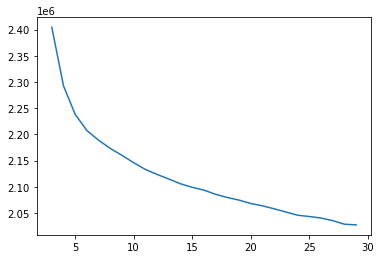

In [19]:
plt.plot(list(elbow.keys()), list(elbow.values()))

In [21]:
kl = KneeLocator(range(3, 20), list(elbow.values())[:17], curve="convex", direction="decreasing")

kl.elbow

6

Text(9, 2292548.6612896775, 'Cluster Size')

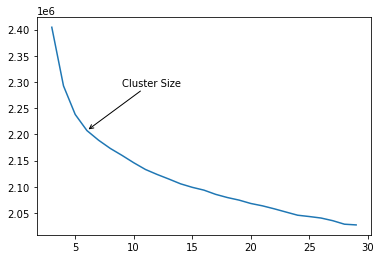

In [38]:
plt.plot(list(elbow.keys()), list(elbow.values()))
plt.annotate("Cluster Size", xy=(6, elbow[6]), xytext=(9, elbow[4]), arrowprops=dict(arrowstyle="->"))

In [8]:
optimal_k = KMeans(n_clusters = 6)
p = optimal_k.fit_predict(svd_2000)

In [11]:
myc, myp = k_means(svd_2000, 6)

provide the number of products in each cluster

In [15]:
pd.Series(p).value_counts()

0    39023
4    18827
2     9237
3     4564
5     1839
1      768
dtype: int64

In [16]:
pd.Series(myp).value_counts()

2    38462
5    18846
1     9372
4     4754
0     2009
3      815
dtype: int64

The numbr of product for each cluster are similar

**wordcloud** of the smallest cluster for each kmeans implementation

(-0.5, 399.5, 199.5, -0.5)

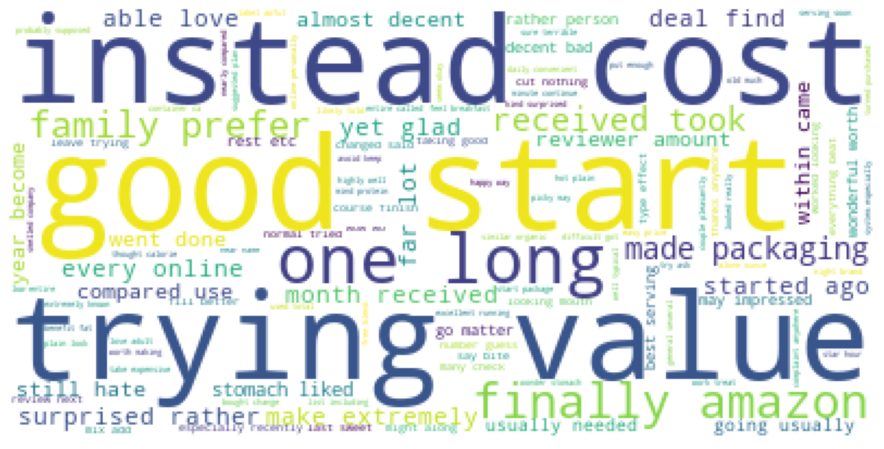

In [79]:
plt.figure(figsize=(16,8))
index = []
for i in range(len(p)):
    if p[i] == 1:
        index.append(i)

plt.subplot()

text = ' '.join(' '.join(set(d[products[i]])) for i in index)

wordcloud = WordCloud(relative_scaling = 1.0, background_color="white").generate(text)

plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

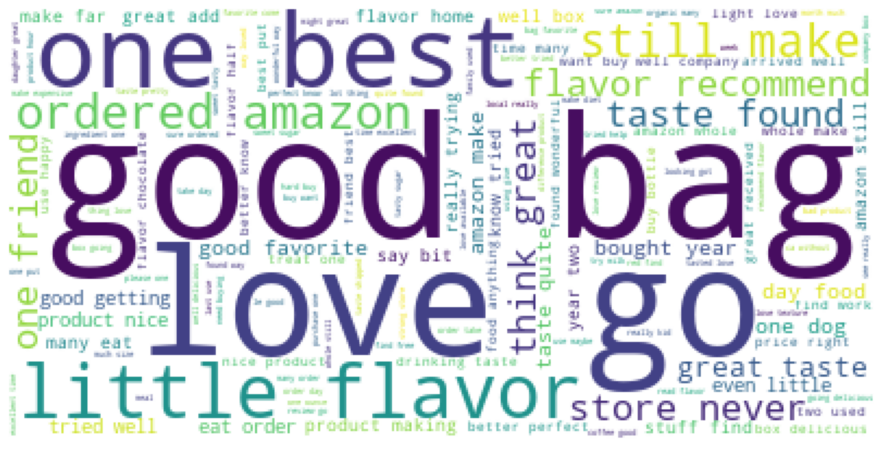

In [22]:
plt.figure(figsize=(16,8))
index = []
for i in range(len(myp)):
    if p[i] == 3:
        index.append(i)

plt.subplot()

text = ' '.join(' '.join(set(d[products[i]])) for i in index)

wordcloud = WordCloud(relative_scaling = 1.0, background_color="white").generate(text)

plt.imshow(wordcloud)
plt.axis('off')

score distribution

In [23]:
labels = defaultdict(list)
for k in range(6):
    for i in range(len(p)):
        labels[k].append(products[i])

In [24]:
mylabels = defaultdict(list)
for k in range(6):
    for i in range(len(myp)):
        labels[k].append(products[i])

In [5]:
import json
with open('D:/Storage file PC/Documenti/Università/Data Science/Anno 1/Semestre 1/Algorthmic Methods of Data Mining/Homeworks/HW4/Question2/words for product.json') as json_file:
    d = json.load(json_file)

In [7]:
svd_2000 = np.load('D:/Storage file PC/Documenti/Università/Data Science/Anno 1/Semestre 1/Algorthmic Methods of Data Mining/Homeworks/HW4/Question2/svd_2000.npy')

In [12]:
np.save('D:/Storage file PC/Documenti/Università/Data Science/Anno 1/Semestre 1/Algorthmic Methods of Data Mining/Homeworks/HW4/Question2/p.npy', p)

In [13]:
np.save('D:/Storage file PC/Documenti/Università/Data Science/Anno 1/Semestre 1/Algorthmic Methods of Data Mining/Homeworks/HW4/Question2/myp.npy', myp)

In [21]:
dsp = pd.DataFrame({'ProductId' : products})
dsp['Cluster'] = p
dsp['MyCluster'] = myp

In [26]:
dsp.sample()

,ProductId,Cluster,MyCluster
43538,B0050CROKC,4,5


In [41]:
ds = pd.merge(ds, dsp, on='ProductId')

In [42]:
ds.sample()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cluster,MyCluster
275791,B000EVLS2O,A2XUZ568CJZIQ3,"Ruth A. Reynols ""book and movie enthusiast""",0,0,5,1224288000,good stuff for my grown up son!,the puffed millet is what my son loved when h...,3,4


In [142]:
ds[ds.Cluster == 0]['Score'].value_counts().values

array([34697,  6328,  5888,  3647,  2738], dtype=int64)

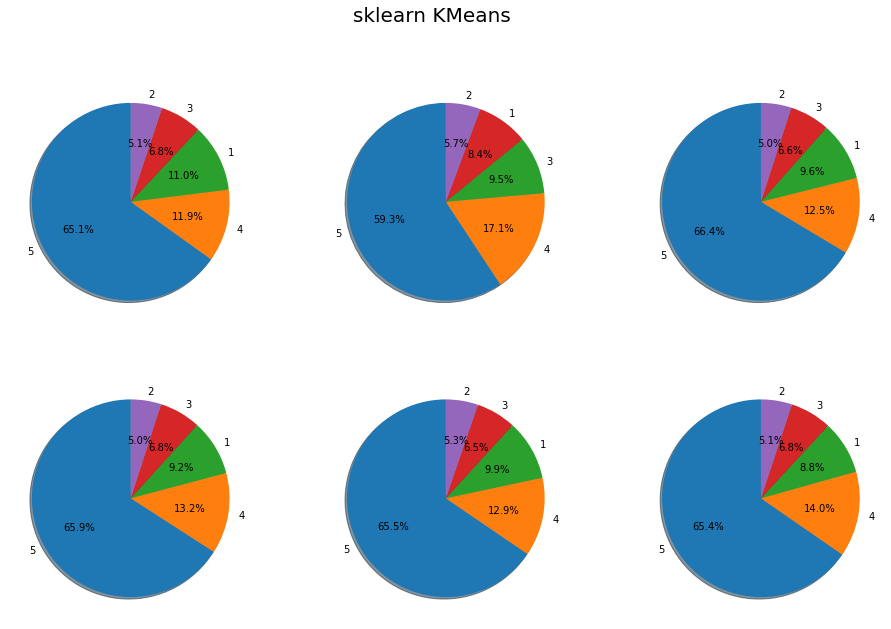

In [146]:
fig, axs = plt.subplots(2, 3, figsize=(16,10))
fig.suptitle('sklearn KMeans', fontsize=20)
axs[0, 0].pie(ds[ds.Cluster == 0]['Score'].value_counts().values, labels=ds[ds.Cluster == 0]['Score'].value_counts().index,  autopct='%1.1f%%', shadow=True, startangle=90)
axs[0, 1].pie(ds[ds.Cluster == 1]['Score'].value_counts().values, labels=ds[ds.Cluster == 1]['Score'].value_counts().index,  autopct='%1.1f%%', shadow=True, startangle=90)
axs[0, 2].pie(ds[ds.Cluster == 2]['Score'].value_counts().values, labels=ds[ds.Cluster == 2]['Score'].value_counts().index,  autopct='%1.1f%%', shadow=True, startangle=90)
axs[1, 0].pie(ds[ds.Cluster == 3]['Score'].value_counts().values, labels=ds[ds.Cluster == 3]['Score'].value_counts().index,  autopct='%1.1f%%', shadow=True, startangle=90)
axs[1, 1].pie(ds[ds.Cluster == 4]['Score'].value_counts().values, labels=ds[ds.Cluster == 4]['Score'].value_counts().index,  autopct='%1.1f%%', shadow=True, startangle=90)
axs[1, 2].pie(ds[ds.Cluster == 5]['Score'].value_counts().values, labels=ds[ds.Cluster == 5]['Score'].value_counts().index,  autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

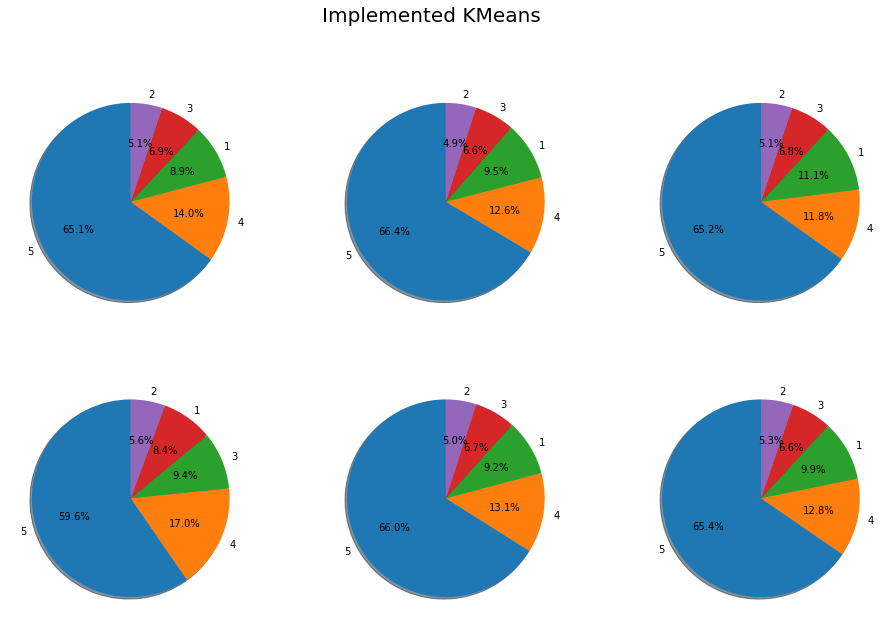

In [147]:
fig, axs = plt.subplots(2, 3, figsize=(16,10))
fig.suptitle('Implemented KMeans', fontsize=20)
axs[0, 0].pie(ds[ds.MyCluster == 0]['Score'].value_counts().values, labels=ds[ds.MyCluster == 0]['Score'].value_counts().index,  autopct='%1.1f%%', shadow=True, startangle=90)
axs[0, 1].pie(ds[ds.MyCluster == 1]['Score'].value_counts().values, labels=ds[ds.MyCluster == 1]['Score'].value_counts().index,  autopct='%1.1f%%', shadow=True, startangle=90)
axs[0, 2].pie(ds[ds.MyCluster == 2]['Score'].value_counts().values, labels=ds[ds.MyCluster == 2]['Score'].value_counts().index,  autopct='%1.1f%%', shadow=True, startangle=90)
axs[1, 0].pie(ds[ds.MyCluster == 3]['Score'].value_counts().values, labels=ds[ds.MyCluster == 3]['Score'].value_counts().index,  autopct='%1.1f%%', shadow=True, startangle=90)
axs[1, 1].pie(ds[ds.MyCluster == 4]['Score'].value_counts().values, labels=ds[ds.MyCluster == 4]['Score'].value_counts().index,  autopct='%1.1f%%', shadow=True, startangle=90)
axs[1, 2].pie(ds[ds.MyCluster == 5]['Score'].value_counts().values, labels=ds[ds.MyCluster == 5]['Score'].value_counts().index,  autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

In [159]:
ds.groupby('Cluster')['Score'].value_counts().describe().std()

30879.924667975687

In [158]:
ds.groupby('MyCluster')['Score'].value_counts().describe().std()

32138.966113905317

The standard deviation is similar

In [183]:
xp = ds.groupby('Cluster')['Score'].value_counts().describe().values[3:]
xmyp = ds.groupby('MyCluster')['Score'].value_counts().describe().values[3:]

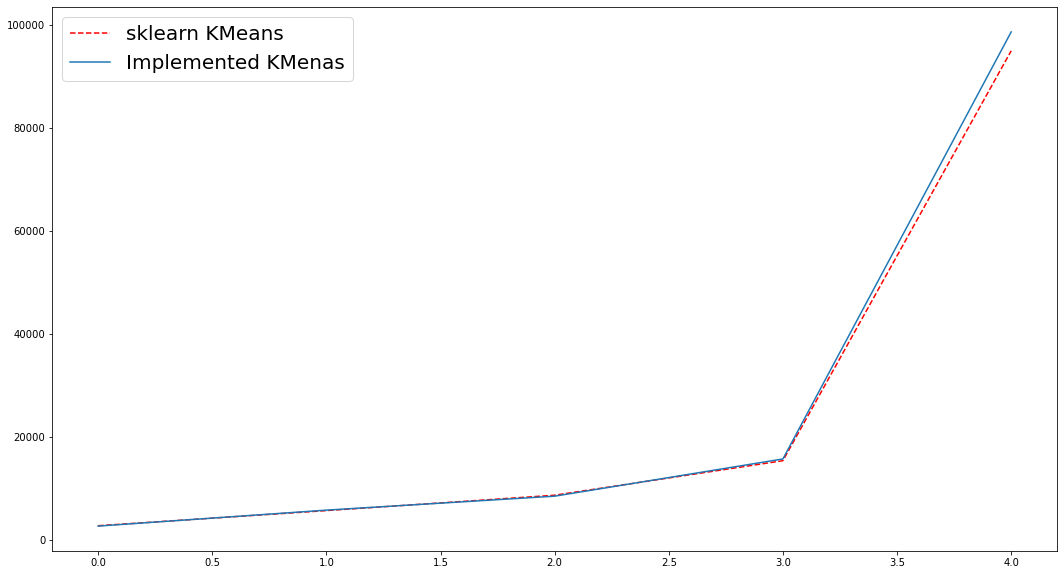

In [211]:
plt.figure(figsize=(18,10))
plt.plot(xp, 'r--', label='sklearn KMeans')
plt.plot(xmyp, '-', label='Implemented KMenas')
plt.legend(fontsize=20)
plt.show()

**Number of user in each cluster**

In [227]:
ds.groupby('Cluster')['UserId'].nunique().sort_values()

Cluster
0    42615
1    45109
4    50964
5    55515
2    60623
3    64675
Name: UserId, dtype: int64

In [228]:
ds.groupby('MyCluster')['UserId'].nunique().sort_values()

MyCluster
2    41747
3    46917
5    49796
0    57792
1    59292
4    64100
Name: UserId, dtype: int64

In [230]:
nu = ds.groupby('Cluster')['UserId'].nunique().sort_values().values
mynu = ds.groupby('MyCluster')['UserId'].nunique().sort_values().values

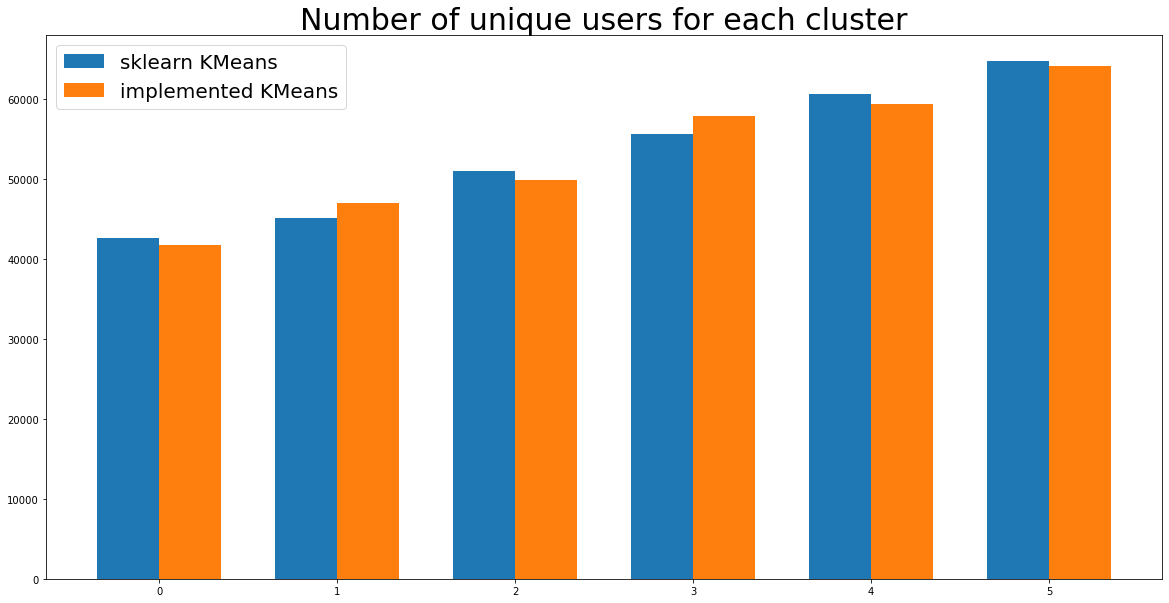

In [260]:
fig, ax = plt.subplots(figsize=(20,10))

x = np.arange(6)
width = 0.35

rects1 = ax.bar(x - width/2, nu, width, label='sklearn KMeans')
rects2 = ax.bar(x + width/2, mynu, width, label='implemented KMeans')

ax.set_title('Number of unique users for each cluster', fontsize=30)
ax.legend(fontsize=20)
plt.show()

Number of users for each clusters is similar